Same dataset as before but with a Variational Autoencoder (VAE). I'm too lazy to preprocess another dataset.

In [1]:
!ulimit -n 4096

In [2]:
import kagglehub

path = kagglehub.dataset_download("splcher/animefacedataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/llukii/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
dataset_path = "/Users/llukii/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3/images"
image_data = []
for image_path in os.listdir(dataset_path)[:10000]:
    image = Image.open("{}/{}".format(dataset_path, image_path))
    image_data.append(image)

In [5]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
batch_size = 32
lr = 0.001
img_size = 64

In [6]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.CenterCrop((img_size, img_size)),
    transforms.ToTensor(),
])

class AnimeDataset(Dataset):
    def __init__(self, data, transform):
        self.transform = transform
        self.data = data

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        return self.transform(self.data[idx])

dataloader = DataLoader(AnimeDataset(image_data, transform), batch_size=32, shuffle=True)

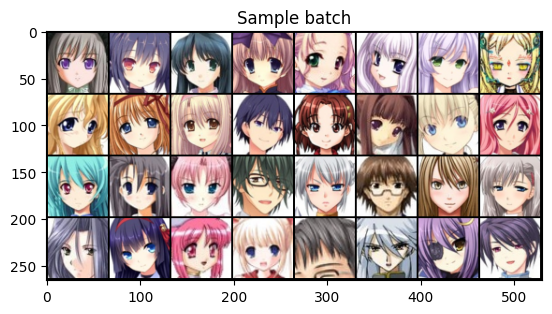

In [7]:
test_batch = next(iter(dataloader))
grid = make_grid(test_batch, nrow=8, normalize=True)
plt.title("Sample batch")
plt.imshow(grid.permute(1, 2, 0))

In [8]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

class UnFlatten(nn.Module):
    def forward(self, x, size=1024):
        return x.view(x.shape[0], size, 1, 1)

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            Flatten()
        )
        self.mean_rep = nn.Linear(1024, 32)
        self.logvar_rep = nn.Linear(1024, 32)
        self.z_to_enc = nn.Linear(32, 1024) # (32, 1024) -> (32, 1024, 1, 1)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(1024, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=6, stride=2),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, x):
        return self.decoder(self.z_to_enc(x))

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mean_rep(encoded)
        logvar = self.logvar_rep(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [10]:
class LossFn(nn.Module):
    def __init__(self):
        super(LossFn, self).__init__()
 # 32, 3, 64, 64
    def forward(self, recon_x, x, mu, logvar):
        bce = F.binary_cross_entropy_with_logits(recon_x.view(recon_x.shape[0], -1), x.view(x.shape[0], -1),
                        reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return bce + kl_div

In [11]:
loss = LossFn().to(device)
model = VAE().to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 15
loss_graph = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for idx, data in enumerate(dataloader):
        data = data.to(device)
        optim.zero_grad()
        recon_x, mu, logvar = model(data)
        cur_loss = loss(recon_x, data, mu, logvar)
        total_loss += cur_loss.detach().item()
        cur_loss.backward()
        optim.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss}")
    loss_graph.append(total_loss)

Epoch 1/15, Loss: 73126326.5390625
Epoch 2/15, Loss: 68369904.3359375
Epoch 3/15, Loss: 66935017.53125
Epoch 4/15, Loss: 66466336.46875
Epoch 5/15, Loss: 66189381.3671875
Epoch 6/15, Loss: 66000301.5546875
Epoch 7/15, Loss: 65865845.0390625
Epoch 8/15, Loss: 65788523.6953125
Epoch 9/15, Loss: 65717884.0234375
Epoch 10/15, Loss: 65662108.1171875
Epoch 11/15, Loss: 65601000.1171875
Epoch 12/15, Loss: 65553673.0625
Epoch 13/15, Loss: 65487199.640625
Epoch 14/15, Loss: 65468011.8046875
Epoch 15/15, Loss: 65419399.28125


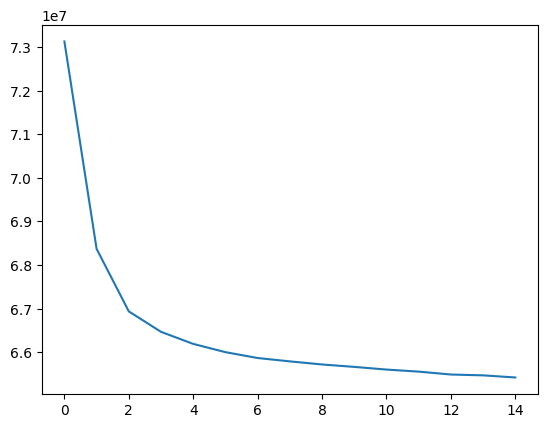

In [12]:
plt.plot(loss_graph)

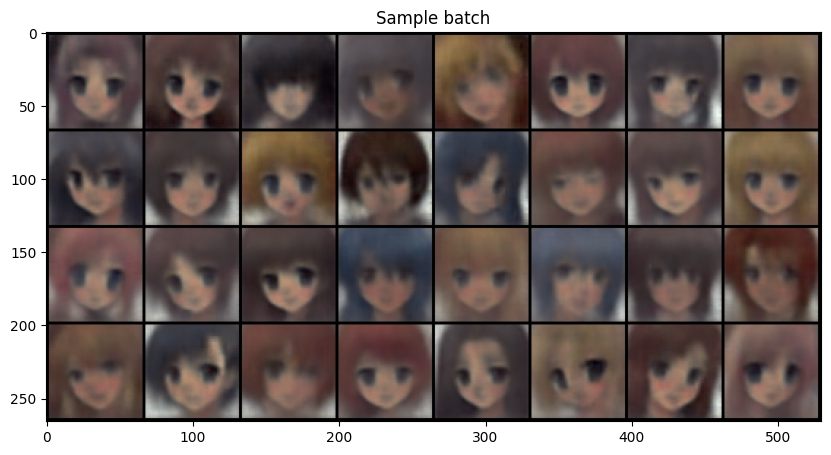

In [14]:
with torch.no_grad():
    model.eval()
    test_batch = next(iter(dataloader))
    decoded, _, _ = model(test_batch.to(device))
    plt.figure(figsize=(10, 10))
    grid = make_grid(decoded.cpu(), nrow=8, normalize=True)
    plt.title("Sample batch")
    plt.imshow(grid.permute(1, 2, 0))